In [1]:
#import the neccesary libraries
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from PIL import Image
import numpy as np
import skimage
import skimage.transform
import os
import tensorflow.keras.backend as K
from skimage.metrics import structural_similarity as ssim
import math
from tensorflow.keras.applications.vgg16 import VGG16
from sobel_edge import sobel 

os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [2]:
import skimage.transform
def CreateSet(input_list,N_patches,patchsize):
    """
    Creates an array that can be used as input and output for the model
    parameters: input_list, a list with indices of the images that are used
                N_patches, the amount of image patches the model creates per image
                patchszize, the width and height of the square image patch
    
    """
    X = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    y = np.zeros((len(input_list)*N_patches, patchsize, patchsize, 1), dtype=np.float32)
    for j in range(N_patches):
        for n,i in enumerate(input_list):
            #random pixel location
            ii = j*len(input_list)+n
            xloc = random.randint(0,401-patchsize)
            yloc = random.randint(0,801-patchsize)
            #input 
            img_input1 = Image.open('bandLimited/input_%03d.png' % (i+1))
            in_img_input1 = tf.keras.preprocessing.image.img_to_array(img_input1)
            in_img_input1 = in_img_input1[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input1 = skimage.transform.resize(in_img_input1 , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)

            #Input from model 2
            img_input2 = Image.open('bandLimited_model2/input_%03d.png' % (i+1))
            in_img_input2 = tf.keras.preprocessing.image.img_to_array(img_input2)
            in_img_input2 = in_img_input2[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_input2 = skimage.transform.resize(in_img_input2 , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)
            X1 = in_img_input1 / 255.0
            X2 = in_img_input2 / 255.0
            X[ii] = X1
            #output
            img_output = Image.open('groundTruth/target_%03d.png' % (i+1))
            in_img_output = tf.keras.preprocessing.image.img_to_array(img_output)
            in_img_output = in_img_output[yloc:yloc+patchsize,xloc:xloc+patchsize]
            in_img_output = skimage.transform.resize(in_img_output , (patchsize , patchsize , 1) , mode = 'constant' , preserve_range = True)

            y[ii] = (in_img_output / 255.0) - X2
            if ii % 1000 == 0:
                    print(ii)
    print('Done')
    return X,y
#amount of patches per image
N_patches = 64
#width and height of the patches
patchsize = 128
#Train set is image 1 till 401
X_train,y_train = CreateSet(range(401),N_patches,patchsize)
#validation set is image 402 till 535
X_valid,y_valid = CreateSet(range(401,535),N_patches,patchsize)

0
1000
2000
3000
4000
5000
6000
7000
8000
9000
10000
11000
12000
13000
14000
15000
16000
17000
18000
19000
20000
21000
22000
23000
24000
25000
Done
0
1000
2000
3000
4000
5000
6000
7000
8000
Done


In [2]:
#Create the arrays for the Test set which are the image 601 till 669
test_set_indices = range(535,669)

Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
for i,n in enumerate(test_set_indices):
    img = Image.open('bandLimited/input_%03d.png' % (n+1))
    in_img_input = tf.keras.preprocessing.image.img_to_array(img)
    in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Test_set_X[i] =in_img_input / 255.0

    img = Image.open('groundTruth/target_%03d.png' % (n+1))
    in_img_output = tf.keras.preprocessing.image.img_to_array(img)
    in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
    Test_set_y[i] =in_img_output / 255.0

In [2]:
def Sobel(x):
    dims = tf.shape (x)#return tf.squeeze( tf.image.sobel_edges(x))
    return tf.reshape(sobel(x),[dims[0],dims[1],dims[2],4])

def Sobel_shape(input_shape):
    dims = [input_shape[0],input_shape[1] ,input_shape[2],4]
    output_shape = tuple(dims)
    return output_shape

def RED_Net(img_tensor , n_filters = 64):
    """
    Creates the RED_net model
    returns: RED_net, the RED_net model
    """
# #     #block1 (connection 1-->2)
    shortcut1 = img_tensor
    
    #layer 1: edge detection layer which uses four kernel filters-
    x = tf.keras.layers.Lambda(Sobel, output_shape =  Sobel_shape, name='sobel-edge')(img_tensor)    #block1 (connection 1-->2)
    
    x = tf.keras.layers.concatenate([x, shortcut1])
    
#     #block 2(connection 2-->9)
    shortcut2 = x
#     #layer 2
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (5 , 5), padding = 'same')(x)
    
    #block 3(connection 3-->8)
    shortcut3 = x
    #layer 3
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=2, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    
#     #block 4 (connection 4-->7)
    shortcut4 = x
    #layer 4
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    
    #layer 5
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=4, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Dropout(0.05)(x)
    
    #layer 6
    x = tf.keras.layers.Conv2D(filters = n_filters , kernel_size = (3 , 3) , dilation_rate=3, padding = 'same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
#     #block 4 (connection 4-->7)
    x = tf.keras.layers.concatenate([x, shortcut4])

    #layer 7
    x = tf.keras.layers.Conv2D(filters = n_filters ,kernel_size = (3 , 3),dilation_rate=2,padding = 'same')(x) 
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('relu')(x)
    
    #block 3(connection 3-->8)    
    x = tf.keras.layers.concatenate([x, shortcut3])

    #layer 8
    x = tf.keras.layers.Conv2D(1 , (3 , 3), padding = 'same')(x)
    #block 2(connection 2-->9)
    x = tf.keras.layers.concatenate([x, shortcut2])

    #layer 9 
    output = tf.keras.layers.Conv2D(1 , (3 , 3) , padding = 'same')(x)

    RED_net = tf.keras.Model(inputs = [img_tensor] , outputs = [output])

    return RED_net

In [3]:
def CustomMSE(y_predict,y_true):
    factor = 1e3
    mse = factor*K.mean(K.square(y_predict-y_true))
    return mse
    

In [4]:
#define and compile the model
img_tensor = tf.keras.layers.Input((None , None , 1) , name = 'img_tensor')
model = RED_Net(img_tensor,64)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=0.0001, beta_1=0.5, beta_2=0.999, epsilon=1e-08, decay=0.0),
            loss=CustomMSE,
            metrics=[tf.keras.metrics.RootMeanSquaredError()])

In [5]:
model_path = 'model_RED_net_cascade_ultrasound.h5'
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10, verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.0001, verbose=1),
    tf.keras.callbacks.ModelCheckpoint(model_path, verbose=1, save_best_only=True, save_weights_only=True)
]

In [8]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
img_tensor (InputLayer)         [(None, None, None,  0                                            
__________________________________________________________________________________________________
sobel-edge (Lambda)             (None, None, None, 4 0           img_tensor[0][0]                 
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, None, 5 0           sobel-edge[0][0]                 
                                                                 img_tensor[0][0]                 
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 6 8064        concatenate[0][0]            

In [9]:
#train the model
results = model.fit(X_train,y_train,epochs=100, callbacks=callbacks,batch_size = 16,
                    validation_data=(X_valid,y_valid),shuffle=False)

Epoch 1/100
1604/1604 [==============================] - ETA: 0s - loss: 16.9706 - root_mean_squared_error: 0.1303
Epoch 00001: val_loss improved from inf to 9.95717, saving model to model_RED_net_cascade_ultrasound.h5
1604/1604 [==============================] - 145s 90ms/step - loss: 16.9706 - root_mean_squared_error: 0.1303 - val_loss: 9.9572 - val_root_mean_squared_error: 0.0998 - lr: 1.0000e-04
Epoch 2/100
1604/1604 [==============================] - ETA: 0s - loss: 9.1378 - root_mean_squared_error: 0.0956
Epoch 00002: val_loss improved from 9.95717 to 9.26598, saving model to model_RED_net_cascade_ultrasound.h5
1604/1604 [==============================] - 146s 91ms/step - loss: 9.1378 - root_mean_squared_error: 0.0956 - val_loss: 9.2660 - val_root_mean_squared_error: 0.0963 - lr: 1.0000e-04
Epoch 3/100
1604/1604 [==============================] - ETA: 0s - loss: 8.6769 - root_mean_squared_error: 0.0931
Epoch 00003: val_loss improved from 9.26598 to 9.02387, saving model to model_

KeyboardInterrupt: 

In [6]:
#load the model
model.load_weights(model_path)

In [ ]:
#visualise the accuracy and losses of the model
# list all data in history
print(results.history.keys())
# summarize history for accuracy
plt.plot(results.history['root_mean_squared_error'])
plt.plot(results.history['val_root_mean_squared_error'])
plt.title('model root_mean_squared_error')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

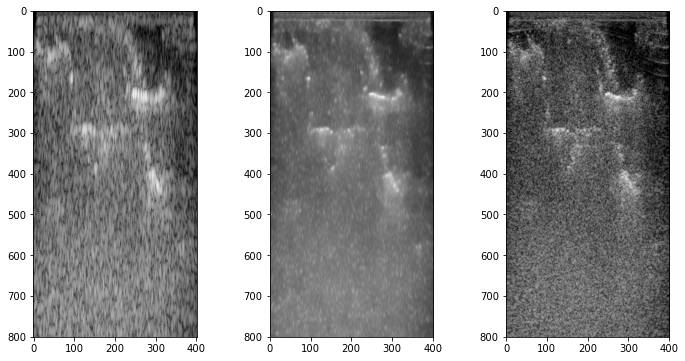

In [16]:
n =2

prediction = model.predict(np.expand_dims(Test_set_X[n], 0))
modeloutput = np.load('Model_output_test_model2_ultrasound.npy')

prediction_image = prediction.squeeze()

fig,ax = plt.subplots(1,3, figsize=(12,6))
ax[0].imshow(Test_set_X[n].squeeze(),cmap = 'gray')
ax[1].imshow(prediction_image+modeloutput[n],cmap='gray')
ax[2].imshow(Test_set_y[n].squeeze(),cmap='gray')
plt.show()

In [7]:
def CreateTestSet(test_set_indices,input_dir_test,output_dir_test):
    """
    Function that reads in the test set images as arrays and scales them between 0 and 1
    parameters:test_set_indices: The indices of the the images in the test set
                 input_dir_test: The directory where the input png images are stored
                output_dir_test: The directory where the output png images are stored
    returns: Test_set_X: an array of input images
             Test_set_y: an array of output images
    """
    Test_set_X = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    Test_set_y = np.zeros((len(test_set_indices), 801, 401, 1), dtype=np.float32)
    for i,n in enumerate(test_set_indices):
        img = Image.open(input_dir_test+'/input_%03d.png' % (n+1))
        in_img_input = tf.keras.preprocessing.image.img_to_array(img)
        in_img_input = skimage.transform.resize(in_img_input , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_X[i] =in_img_input / 255.0

        img = Image.open(output_dir_test+'/target_%03d.png' % (n+1))
        in_img_output = tf.keras.preprocessing.image.img_to_array(img)
        in_img_output = skimage.transform.resize(in_img_output , (801 , 401 , 1) , mode = 'constant' , preserve_range = True)
        Test_set_y[i] =in_img_output / 255.0    
    print('Done')
    return Test_set_X, Test_set_y
#run for all data sets
for dataset in ['','CIRS_','carotid_']:
    if dataset == '':
        test_set_indices = range(535,669)
        input_dir_test = 'bandLimited'
        output_dir_test = 'groundTruth'
    if dataset == 'CIRS_':
        test_set_indices = range(11)
        input_dir_test = 'CIRSBandLimited'
        output_dir_test = 'CIRSGroundTruth'
    if dataset =='carotid_':
        test_set_indices = range(70)
        input_dir_test = 'carotidBandLimited'
        output_dir_test = 'carotidGroundTruth'
    #create the input and output for the test set
    Test_set_X, Test_set_y = CreateTestSet(test_set_indices,input_dir_test,output_dir_test)
    modeloutput = np.load('Model_output_test_'+dataset+'model2_ultrasound.npy')\
    #Create an array of predicted images
    prediction_images = np.zeros_like(Test_set_X.squeeze())
    for i in range(len(Test_set_X)):
        predicted_array = model.predict(np.expand_dims(Test_set_X[i] , 0))
        prediction_IMAGE = modeloutput[i]+predicted_array.squeeze()
        prediction_images[i] = prediction_IMAGE
    #save the predicted array in a NPY file
    np.save('Model_output_test_'+dataset+'model3_ultrasound.npy',prediction_images)

Done
Done
Done
